In [ ]:
from models import preflop_model

model = preflop_model()
model.summary()



In [ ]:
from pushfold import PushFoldEmulator

import numpy as np

emul = PushFoldEmulator(200,10)
num_hands =500000
total_reward = 0

e = 0.10
loss = []

sb_pushed_plt = []
bb_called_plt = []

state_sb = np.zeros((16))
state_bb = np.zeros((16))

targetQ = np.zeros((2))

bankroll_sb = [0]
bankroll_player1 = [0]
player1 = True

replay_state = []
replay_Q = []
max_replay = 10000

sb_pushed = 0
bb_called = 0


for i in range(num_hands):
    reward_sb = 0
    reward_bb = 0

  
    emul.new_hand(np.random.randint(80,400))

    emul.get_hand_feature()

    sb_features = np.concatenate([emul.players_cards[1],np.array([emul.suited[0],1,emul.starting_stack/400])]).reshape((1,16))
    bb_features = np.concatenate([emul.players_cards[0],np.array([emul.suited[1],0,emul.starting_stack/400])]).reshape((1,16))
    
    replay_state.append(sb_features.reshape((16,)))
    
    
    #run model to choose action
    allQ_sb = model.predict(sb_features)
    action_sb = np.argmax(allQ_sb)
    allQ_bb = model.predict(bb_features)
    action_bb = np.argmax(allQ_bb)

    #randomly discover new line
    if(np.random.rand(1) < e):

        action_sb = np.random.randint(0,2)
        action_bb = np.random.randint(0,2)
        
    emul.play_action(action_sb)
    if action_sb == 1:
        sb_pushed +=1
    
    if emul.is_round_finished() == False:
        emul.play_action(action_bb)     
        if action_sb == 1:
            if action_bb == 1:
                bb_called +=1
            

    r  = emul.get_sb_reward()
    total_reward +=r
    bankroll_sb.append(bankroll_sb[-1]+r)
    
    allQ_sb[0,action_sb] = r
    replay_Q.append(allQ_sb.reshape((2,)))
    
    #train only if sb played. otherwise positive reward for folding
    if action_sb == 1:
        replay_state.append(bb_features.reshape((16,)))
        allQ_bb[0,action_bb] = -r
        replay_Q.append(allQ_bb.reshape((2,)))
    

    if player1 == True:
        player1 = False
        bankroll_player1.append(bankroll_player1[-1]+r)
    else:
        player1 = True
        bankroll_player1.append(bankroll_player1[-1]-r)

    if(i%10000== 0 and i > 0):
        sb_pushed_pct = int(sb_pushed/(i+1)*100)
        sb_pushed_plt.append(sb_pushed_pct)
        bb_called_pct = int(bb_called/(sb_pushed+1)*100)
        bb_called_plt.append(bb_called_pct)
        print('\n\nround',i)
        print('Won(SB):',r,'  Total won (SB):',total_reward)
        print('SB pushed ' + str(sb_pushed_pct)+'% , BB called '+  str(bb_called_pct)+'%' )
        print('sb_features')
        print(sb_features)
        print('allQ_sb:')
        print(allQ_sb)
        print('\nbb_features')
        print(bb_features)
        print('allQ_bb:')   
        print(allQ_bb)
        
        print(emul.get_action_histories_text(hole_cards = True))
        
        #print(emul.events)
        
        model.fit(np.stack(replay_state),np.stack(replay_Q),verbose=1)


    if(len(replay_state) > max_replay):
        replay_state = replay_state[50:]
        replay_Q = replay_Q[50:]


In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(sb_pushed_plt[1:])
plt.plot(bb_called_plt[1:])

NameError: name 'sb_pushed_plt' is not defined

In [3]:
from metrics import compute_nash_pusher
from metrics import compute_nash_caller
call_nash = compute_nash_caller(model)
push_chart = compute_nash_pusher(model)

In [ ]:
from models import save_model

save_model(model,'pushfold')

In [1]:
from models import load

model = load('pushfold')

Using TensorFlow backend.


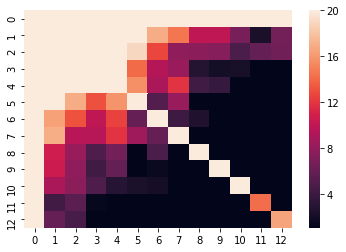

In [4]:
sns.heatmap(push_chart)

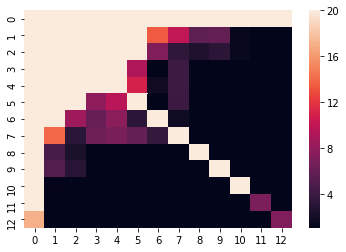

In [6]:
sns.heatmap(call_nash)

In [7]:
call_nash

array([[ 20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,
         20. ,  20. ,  20. ,  20. ],
       [ 20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  13.5,  10.1,   5.7,
          5.9,   1.4,   1.1,   1.1],
       [ 20. ,  20. ,  20. ,  20. ,  20. ,  20. ,   7.3,   3.4,   2.7,
          3.3,   1.5,   1.1,   1.1],
       [ 20. ,  20. ,  20. ,  20. ,  20. ,   9.3,   1.1,   4.1,   1.1,
          1.1,   1.1,   1.1,   1.1],
       [ 20. ,  20. ,  20. ,  20. ,  20. ,  11. ,   1.9,   4.2,   1.1,
          1.1,   1.1,   1.1,   1.1],
       [ 20. ,  20. ,  20. ,   7.9,   9.7,  20. ,   1.1,   4. ,   1.1,
          1.1,   1.1,   1.1,   1.1],
       [ 20. ,  20. ,   8.6,   6.1,   7.8,   3.2,  20. ,   1.8,   1.1,
          1.1,   1.1,   1.1,   1.1],
       [ 20. ,  14. ,   3.2,   6.4,   6.9,   6. ,   3.7,  20. ,   1.1,
          1.1,   1.1,   1.1,   1.1],
       [ 20. ,   4.7,   2.5,   1.1,   1.1,   1.1,   1.1,   1.1,  20. ,
          1.1,   1.1,   1.1,   1.1],
       [ 20. ,   5.1,   3.1,